In [4]:
import torch
import torch.nn as nn

In [5]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import yfinance as yf


In [49]:
# Step 1: Fetch the data.
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOGL", "GOLD", "VNQ", "QQQ"]
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=10)
data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
returns = data.pct_change().dropna()
returns = returns[tickers]

X = np.array(returns[["META", "AAPL", "AMZN", "NFLX", "GOOGL", "GOLD", "VNQ"]].values)
Y = np.array(returns[["QQQ","QQQ"]].values)
# X = np.array(returns.iloc[:-1, :].values)
# Y = np.array(returns.iloc[1:, :].values)

[*********************100%%**********************]  8 of 8 completed


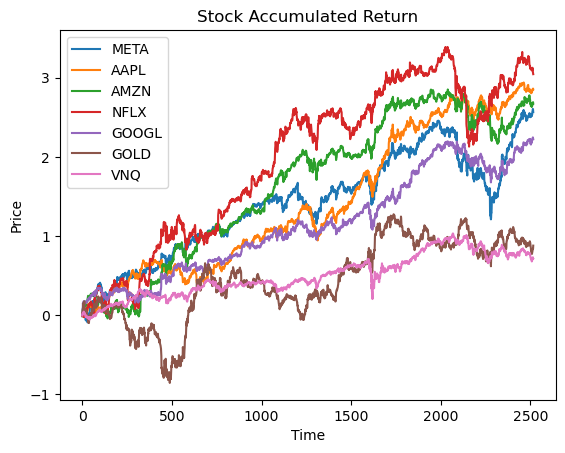

In [50]:
# plot the data
import matplotlib.pyplot as plt
plt.plot(X.cumsum(axis=0))
# labels
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Accumulated Return')

plt.legend(tickers)
plt.show()

Now, 
I have 6 timeseries array X = [x1, x2, x3..] and 2 timeseries tag array Y, 
I define the LSTM model as follows, use ChatGPT to write code to train the model using K-fold

In [187]:
class GroupLassoLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lambda_):
        super(GroupLassoLSTM, self).__init__()
        self.input_dim = input_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True) # what is batch_first? batch, seq_len, input_size
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.lambda_ = lambda_

    def forward(self, x, y):
        h1, _ = self.lstm1(x)
        h2, _ = self.lstm2(h1)
        out = self.fc(h2)

        # Grouped lasso penalty
        lasso_penalty = 0
        for i in range(self.input_dim):
            # instead of using norm2, we use max of each group
            group = self.lstm1.weight_ih_l0[:, i]
            # lasso_penalty += torch.max(torch.abs(group))
            lasso_penalty += torch.norm(group, p=2)
        loss = nn.MSELoss()(out, y) + self.lambda_ * lasso_penalty
        return loss
    # define r-squared
    def r2(self, x, y):
        h1, _ = self.lstm1(x)
        h2, _ = self.lstm2(h1)
        out = self.fc(h2)
        out = out.detach().numpy()
        y = y.detach().numpy()
        r2 = r2_score(y, out)
        return r2
    # why r-squared could negative? worse then constant model
    # Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    # A constant model that always predicts the expected value of y, disregarding the input features,would get a R^2 score of 0.0.
'''
Here, lambda_ is the regularization parameter for the grouped lasso penalty. 
The torch.norm() function is used to compute the L2 norm of each group of weights in the LSTM layers.
'''



'\nHere, lambda_ is the regularization parameter for the grouped lasso penalty. \nThe torch.norm() function is used to compute the L2 norm of each group of weights in the LSTM layers.\n'

In [64]:
# optim
import torch.optim as optim
# using rolling K-fold to train the model
from sklearn.model_selection import TimeSeriesSplit

# Define the number of folds for cross-validation
k_folds = 10

# Define the hyperparameters for the model
input_dim = X.shape[1]
hidden_dim = 32
output_dim = Y.shape[1]
lambda_ = 1e-5

# Define the loss function and optimizer
criterion = GroupLassoLSTM(input_dim, hidden_dim, output_dim, lambda_)

# Define the K-fold rolling
kfold = TimeSeriesSplit(n_splits=k_folds)

# Split the data into K-folds and train the model on each fold
for fold, (train_indices, val_indices) in enumerate(kfold.split(X)):
    # Split the data into training and validation sets for this fold
    optimizer = optim.Adam(criterion.parameters(), lr=0.001)
    X_train, y_train = X[train_indices], Y[train_indices]
    X_val, y_val = X[val_indices], Y[val_indices]

    # Convert the data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train).float()
    y_train_tensor = torch.tensor(y_train).float()
    X_val_tensor = torch.tensor(X_val).float()
    y_val_tensor = torch.tensor(y_val).float()

    # Train the model on this fold
    for epoch in range(100): # 100 epochs
        optimizer.zero_grad() # clear gradients
        loss = criterion(X_train_tensor, y_train_tensor) # compute loss
        loss.backward() # compute gradients
        optimizer.step() # update the parameters

    # Evaluate the model on this fold
    with torch.no_grad(): # temporarily set all the requires_grad flag to false
        val_loss = criterion(X_val_tensor, y_val_tensor)
        print(f"Fold {fold + 1}: Validation Loss: {val_loss:.6f}")
        print(f"Fold {fold + 1}: Validation R2: {criterion.r2(X_val_tensor, y_val_tensor):.2f}")
        
        

Fold 1: Validation Loss: 0.0001
Fold 1: Validation R2: -0.0128
Fold 2: Validation Loss: 0.0002
Fold 2: Validation R2: -0.0285
Fold 3: Validation Loss: 0.0000
Fold 3: Validation R2: 0.0954
Fold 4: Validation Loss: 0.0001
Fold 4: Validation R2: 0.5912
Fold 5: Validation Loss: 0.0000
Fold 5: Validation R2: 0.8919
Fold 6: Validation Loss: 0.0000
Fold 6: Validation R2: 0.8825
Fold 7: Validation Loss: 0.0001
Fold 7: Validation R2: 0.9129
Fold 8: Validation Loss: 0.0000
Fold 8: Validation R2: 0.8278
Fold 9: Validation Loss: 0.0000
Fold 9: Validation R2: 0.9356
Fold 10: Validation Loss: 0.0000
Fold 10: Validation R2: 0.8691


In [53]:

for fold, (train_indices, val_indices) in enumerate(kfold.split(X)):
    print(train_indices[0], train_indices[-1], val_indices[0], val_indices[-1])

0 236 237 464
0 464 465 692
0 692 693 920
0 920 921 1148
0 1148 1149 1376
0 1376 1377 1604
0 1604 1605 1832
0 1832 1833 2060
0 2060 2061 2288
0 2288 2289 2516


In [54]:
# print the model architecture
print(criterion)


GroupLassoLSTM(
  (lstm1): LSTM(7, 32, batch_first=True)
  (lstm2): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


In [67]:
# # print the parameters of the first LSTM layer, 
# print(criterion.lstm1.weight_ih_l0.shape) # the input-to-hidden weights
# print(criterion.lstm1.weight_ih_l0) # the hidden-to-hidden weights
# print(criterion.lstm1.bias_ih_l0) # the input-to-hidden bias


In [65]:
# out put the i-th colums of the input-to-hidden weights
criterion.lstm1.weight_ih_l0[:, 6]

#the norm2 values of the i-th column of the input-to-hidden weights
torch.norm(criterion.lstm1.weight_ih_l0[:, 6], p=2)

# sum of the norm2 of each columns of the input-to-hidden weights
for i in range(7):
    print(torch.norm(criterion.lstm1.weight_ih_l0[:, i], p=4))


tensor(0.0679, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.2906, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.1324, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0528, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.2163, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0004, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.1758, grad_fn=<LinalgVectorNormBackward0>)


## from L-2 norm to L-infinite norm

In [68]:
class GroupLassoLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lambda_):
        super(GroupLassoLSTM, self).__init__()
        self.input_dim = input_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True) # what is batch_first? batch, seq_len, input_size
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.lambda_ = lambda_

    def forward(self, x, y):
        h1, _ = self.lstm1(x)
        h2, _ = self.lstm2(h1)
        out = self.fc(h2)

        # Grouped lasso penalty
        lasso_penalty = 0
        for i in range(self.input_dim):
            # instead of using norm2, we use max of each group
            group = self.lstm1.weight_ih_l0[:, i]
            # lasso_penalty += torch.max(torch.abs(group))
            lasso_penalty += torch.max(torch.abs(group))
        loss = nn.MSELoss()(out, y) + self.lambda_ * lasso_penalty
        return loss
    # define r-squared
    def r2(self, x, y):
        h1, _ = self.lstm1(x)
        h2, _ = self.lstm2(h1)
        out = self.fc(h2)
        out = out.detach().numpy()
        y = y.detach().numpy()
        r2 = r2_score(y, out)
        return r2
    # why r-squared could negative? worse then constant model
    # Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    # A constant model that always predicts the expected value of y, disregarding the input features,would get a R^2 score of 0.0.




'''
Here, lambda_ is the regularization parameter for the grouped lasso penalty. 
The torch.norm() function is used to compute the L2 norm of each group of weights in the LSTM layers.
'''



'\nHere, lambda_ is the regularization parameter for the grouped lasso penalty. \nThe torch.norm() function is used to compute the L2 norm of each group of weights in the LSTM layers.\n'

In [160]:
# optim
import torch.optim as optim
# using rolling K-fold to train the model
from sklearn.model_selection import TimeSeriesSplit

# Define the number of folds for cross-validation
k_folds = 20

# Define the hyperparameters for the model
input_dim = X.shape[1]
hidden_dim = 8
output_dim = Y.shape[1]
lambda_ = 1e-5
loss = 10 # early stopping

weight_pd = pd.DataFrame()
for lambda_ in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    # Define the loss function and optimizer
    criterion = GroupLassoLSTM(input_dim, hidden_dim, output_dim, lambda_)

    # Define the K-fold rolling
    kfold = TimeSeriesSplit(n_splits=k_folds)

    # Split the data into K-folds and train the model on each fold
    for fold, (train_indices, val_indices) in enumerate(kfold.split(X)):
        # Split the data into training and validation sets for this fold
        optimizer = optim.Adam(criterion.parameters(), lr=0.001) # lr = learning rate, 
        X_train, y_train = X[train_indices], Y[train_indices]
        X_val, y_val = X[val_indices], Y[val_indices]

        # Convert the data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train).float()
        y_train_tensor = torch.tensor(y_train).float()
        X_val_tensor = torch.tensor(X_val).float()
        y_val_tensor = torch.tensor(y_val).float()

        # Train the model on this fold
        
        for epoch in range(500): # 100 epochs
            if loss < 0.00001:
                print("early stopping")
                break
            optimizer.zero_grad() # clear gradients
            loss = criterion(X_train_tensor, y_train_tensor) # compute loss
            loss.backward() # compute gradients
            optimizer.step() # update the parameters

        # Evaluate the model on this fold
        with torch.no_grad(): # temporarily set all the requires_grad flag to false
            val_loss = criterion(X_val_tensor, y_val_tensor)
            print(f"Fold {fold + 1}: Validation Loss: {val_loss:.8f}")
            print(f"Fold {fold + 1}: Validation R2: {criterion.r2(X_val_tensor, y_val_tensor):.4f}")
    weight = {}
    # sum of the norm2 of each columns of the input-to-hidden weights
    for i in range(7):
        weight[tickers[i]] = torch.norm(criterion.lstm1.weight_ih_l0[:, i], p=1).item()
    weight['R2'] = criterion.r2(X_val_tensor, y_val_tensor)
    weight_pd = pd.concat([weight_pd, pd.DataFrame(weight, index = [lambda_])])
        

Fold 1: Validation Loss: 0.00023420
Fold 1: Validation R2: -2.7266
Fold 2: Validation Loss: 0.00005089
Fold 2: Validation R2: 0.5214
Fold 3: Validation Loss: 0.00004090
Fold 3: Validation R2: 0.8119
Fold 4: Validation Loss: 0.00003816
Fold 4: Validation R2: 0.8277
Fold 5: Validation Loss: 0.00002964
Fold 5: Validation R2: 0.7295
Fold 6: Validation Loss: 0.00002346
Fold 6: Validation R2: 0.6797
Fold 7: Validation Loss: 0.00001871
Fold 7: Validation R2: 0.8016
Fold 8: Validation Loss: 0.00002127
Fold 8: Validation R2: 0.8396
Fold 9: Validation Loss: 0.00002954
Fold 9: Validation R2: 0.8424
Fold 10: Validation Loss: 0.00002923
Fold 10: Validation R2: 0.9215
Fold 11: Validation Loss: 0.00002192
Fold 11: Validation R2: 0.8380
Fold 12: Validation Loss: 0.00002060
Fold 12: Validation R2: 0.8590
Fold 13: Validation Loss: 0.00006253
Fold 13: Validation R2: 0.9308
Fold 14: Validation Loss: 0.00003268
Fold 14: Validation R2: 0.9006
Fold 15: Validation Loss: 0.00003794
Fold 15: Validation R2: 0.81

In [186]:
select_ = [ 20 * i -1 for i in range(1, 6)] 
select_
weight_pd.reset_index(names='lambda_').iloc[select_, :]

,lambda_,META,AAPL,AMZN,NFLX,GOOGL,GOLD,VNQ,R2
19,0.00001,1.277586,5.536772,2.555223,1.030013,4.148103,0.027514,3.610357,0.799462
39,0.00010,0.365287,2.020213,0.833481,0.281094,1.424724,0.023982,0.905247,0.822545
59,0.00100,0.023953,0.033186,0.021843,0.021831,0.020359,0.028744,0.023666,0.005810
79,0.01000,0.026503,0.021565,0.025750,0.032404,0.019731,0.018122,0.022776,0.020834
99,0.10000,0.018581,0.019310,0.023028,0.016463,0.024656,0.022140,0.022156,0.002670


lambda_
0.00001    Axes(0.125,0.11;0.775x0.77)
0.00010    Axes(0.125,0.11;0.775x0.77)
0.00100    Axes(0.125,0.11;0.775x0.77)
0.01000    Axes(0.125,0.11;0.775x0.77)
0.10000    Axes(0.125,0.11;0.775x0.77)
Name: R2, dtype: object

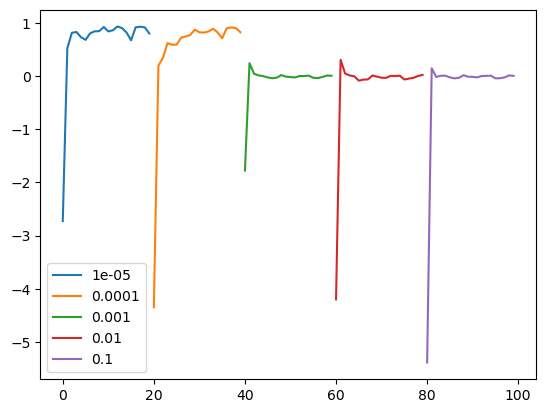

In [174]:
# plot R-2's changing path in training in different lambda 
weight_pd.reset_index(names='lambda_').groupby('lambda_')['R2'].plot(legend=True)

Text(0, 0.5, 'norm 1 of first layer weight')

<Figure size 1800x500 with 0 Axes>

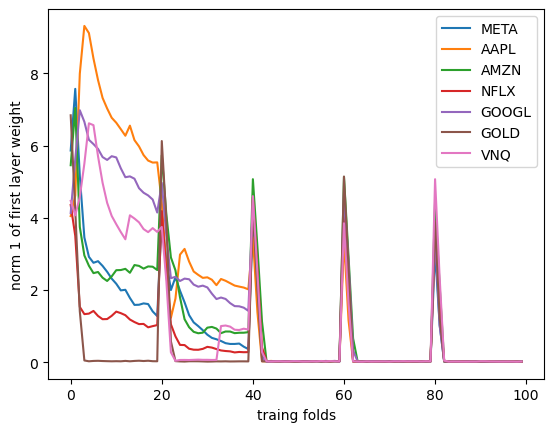

In [182]:
# plot paras' changing path in training in different lambda 
# set figure size
plt.figure(figsize=(18, 5))
# set subplots size
weight_pd.reset_index(names='lambda_')[["META", "AAPL", "AMZN", "NFLX", "GOOGL", "GOLD", "VNQ"]].plot(legend=True)
# set labels
plt.xlabel('traing folds')
plt.ylabel('norm 1 of first layer weight')

In [8]:
import numpy as np
import pandas as pd
# Set a seed for reproducibility
np.random.seed(42)

# Number of data points
n = 1000

# Generate synthetic stock returns
stock_1 = np.random.randn(n) * 0.01
stock_2 = np.random.randn(n) * 0.01
stock_3 = np.random.randn(n) * 0.01

# These stocks are uncorrelated with the index fund return
stock_4 = np.random.randn(n) * 0.01
stock_5 = np.random.randn(n) * 0.01

# Generate an index fund return based on lagged returns of the first 3 stocks
# We are introducing some delay to mimic the "lagged" influence.
index_return = 0.25 * stock_1[:-1] + 0.25 * stock_2[:-1] + 0.5 * stock_3[:-1] + np.random.randn(n-1) * 0.001

# Create dataframe
stock_data = pd.DataFrame({
    'stock_1': stock_1[1:],
    'stock_2': stock_2[1:],
    'stock_3': stock_3[1:],
    'stock_4': stock_4[1:],
    'stock_5': stock_5[1:]
})

index_data = pd.DataFrame({'index_return': index_return})
lagged_data = pd.DataFrame()
tickers = ['stock_1', 'stock_2', 'stock_3', 'stock_4', 'stock_5']
lags = 2
# If you want to add lagged features, you can do so:
for stock in tickers:
    lagged_data[f'{stock}_lag1'] = stock_data[stock].shift(1)
    lagged_data[f'{stock}_lag2'] = stock_data[stock].shift(2)

lagged_data = lagged_data.iloc[2:]
index_data = index_data.iloc[2:]

In [19]:
X = np.array(lagged_data.values)
Y = np.array(index_data[['index_return','index_return']].values)
tickers = lagged_data.columns

In [6]:
class GroupLassoLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lambda_):
        super(GroupLassoLSTM, self).__init__()
        self.input_dim = input_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True) # what is batch_first? batch, seq_len, input_size
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.lambda_ = lambda_

    def forward(self, x, y):
        h1, _ = self.lstm1(x)
        h2, _ = self.lstm2(h1)
        out = self.fc(h2)

        # Grouped lasso penalty
        lasso_penalty = 0
        for i in range(self.input_dim):
            # instead of using norm2, we use max of each group
            group = self.lstm1.weight_ih_l0[:, i]
            # lasso_penalty += torch.max(torch.abs(group))
            lasso_penalty += torch.max(torch.abs(group))
        loss = nn.MSELoss()(out, y) + self.lambda_ * lasso_penalty
        return loss
    # define r-squared
    def r2(self, x, y):
        h1, _ = self.lstm1(x)
        h2, _ = self.lstm2(h1)
        out = self.fc(h2)
        out = out.detach().numpy()
        y = y.detach().numpy()
        r2 = r2_score(y, out)
        return r2
    # why r-squared could negative? worse then constant model
    # Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    # A constant model that always predicts the expected value of y, disregarding the input features,would get a R^2 score of 0.0.




'''
Here, lambda_ is the regularization parameter for the grouped lasso penalty. 
The torch.norm() function is used to compute the L2 norm of each group of weights in the LSTM layers.
'''



'\nHere, lambda_ is the regularization parameter for the grouped lasso penalty. \nThe torch.norm() function is used to compute the L2 norm of each group of weights in the LSTM layers.\n'

In [28]:
# optim
import torch.optim as optim
# using rolling K-fold to train the model
from sklearn.model_selection import TimeSeriesSplit

# Define the number of folds for cross-validation
k_folds = 20

# Define the hyperparameters for the model
input_dim = X.shape[1]
hidden_dim = 8
output_dim = Y.shape[1]
lambda_ = 1e-5
loss = 10 # early stopping

weight_pd = pd.DataFrame()
for lambda_ in [1e-6, 5e-6, 1e-5, 5e-5,1e-4]:
    # Define the loss function and optimizer
    criterion = GroupLassoLSTM(input_dim, hidden_dim, output_dim, lambda_)

    # Define the K-fold rolling
    kfold = TimeSeriesSplit(n_splits=k_folds)

    # Split the data into K-folds and train the model on each fold
    for fold, (train_indices, val_indices) in enumerate(kfold.split(X)):
        # Split the data into training and validation sets for this fold
        optimizer = optim.Adam(criterion.parameters(), lr=0.001) # lr = learning rate, 
        X_train, y_train = X[train_indices], Y[train_indices]
        X_val, y_val = X[val_indices], Y[val_indices]

        # Convert the data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train).float()
        y_train_tensor = torch.tensor(y_train).float()
        X_val_tensor = torch.tensor(X_val).float()
        y_val_tensor = torch.tensor(y_val).float()

        # Train the model on this fold
        
        for epoch in range(500): # 100 epochs
            if loss < 0.0000001:
                print("early stopping")
                break
            optimizer.zero_grad() # clear gradients
            loss = criterion(X_train_tensor, y_train_tensor) # compute loss
            loss.backward() # compute gradients
            optimizer.step() # update the parameters

        # Evaluate the model on this fold
        with torch.no_grad(): # temporarily set all the requires_grad flag to false
            val_loss = criterion(X_val_tensor, y_val_tensor)
            print(f"Fold {fold + 1}: Validation Loss: {val_loss:.8f}")
            print(f"Fold {fold + 1}: Validation R2: {criterion.r2(X_val_tensor, y_val_tensor):.4f}")
    weight = {}
    # sum of the norm2 of each columns of the input-to-hidden weights
    for i in range(X.shape[1]):
        weight[tickers[i]] = torch.norm(criterion.lstm1.weight_ih_l0[:, i], p=1).item()
    weight['R2'] = criterion.r2(X_val_tensor, y_val_tensor)
    weight_pd = pd.concat([weight_pd, pd.DataFrame(weight, index = [lambda_])])
        

Fold 1: Validation Loss: 0.00061959
Fold 1: Validation R2: -18.3527
Fold 2: Validation Loss: 0.00001138
Fold 2: Validation R2: 0.7808
Fold 3: Validation Loss: 0.00000383
Fold 3: Validation R2: 0.9676
Fold 4: Validation Loss: 0.00000465
Fold 4: Validation R2: 0.9350
Fold 5: Validation Loss: 0.00000389
Fold 5: Validation R2: 0.9495
Fold 6: Validation Loss: 0.00000256
Fold 6: Validation R2: 0.9721
Fold 7: Validation Loss: 0.00000342
Fold 7: Validation R2: 0.9425
Fold 8: Validation Loss: 0.00000302
Fold 8: Validation R2: 0.9666
Fold 9: Validation Loss: 0.00000267
Fold 9: Validation R2: 0.9528
Fold 10: Validation Loss: 0.00000414
Fold 10: Validation R2: 0.9305
Fold 11: Validation Loss: 0.00000332
Fold 11: Validation R2: 0.9567
Fold 12: Validation Loss: 0.00000301
Fold 12: Validation R2: 0.9582
Fold 13: Validation Loss: 0.00000424
Fold 13: Validation R2: 0.9129
Fold 14: Validation Loss: 0.00000252
Fold 14: Validation R2: 0.9632
Fold 15: Validation Loss: 0.00000233
Fold 15: Validation R2: 0.9

KeyboardInterrupt: 

In [29]:
weight_pd

,stock_1_lag1,stock_1_lag2,stock_2_lag1,stock_2_lag2,stock_3_lag1,stock_3_lag2,stock_4_lag1,stock_4_lag2,stock_5_lag1,stock_5_lag2,R2
0.000001,7.244805,0.026104,7.592777,0.025866,14.780114,0.023720,0.040367,0.026134,0.048722,0.029768,0.956229
0.000005,3.633245,0.025014,3.679295,0.028831,7.348546,0.016838,0.022018,0.027332,0.027620,0.026803,0.958272
0.000010,6.981223,0.020471,6.953534,0.021675,16.281487,0.025653,0.028657,0.029129,0.024151,0.027560,0.766220
0.000050,0.020945,0.016137,0.022559,0.023836,0.028361,0.021130,0.028910,0.022572,0.021503,0.018847,-0.037135
